In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

In [2]:
from IPython.display import display, set_matplotlib_formats

In [3]:
# Set the matplotlib graphs to be exported as svg
set_matplotlib_formats('svg')

In [4]:
# Output markdown to cells
from IPython.display import Markdown

---
## Peak event data

In [5]:
# Read Peak event data
url_path = 'https://data.gov.au/dataset/4e21dea3-9b87-4610-94c7-15a8a77907ef/resource/e45517ea-189a-4d61-b02d-bd7d85b0f156/download/sgsc-ctpeak-events.csv'
peak_event_df = pd.read_csv(url_path)

In [6]:
# Trim leading and trailing whitespaces in column names
peak_event_df.columns = peak_event_df.columns.str.strip()

In [7]:
peak_event_df.head()

,EVENT_KEY,PEAK_EVENT_TYPE,EVENT_DATE,START_TIMESTAMP,END_TIMESTAMP,HALF_HOUR_START_CD,HALF_HOUR_END_CD
0,1000240,DPR,17/01/2013 13:00,17/01/2013 12:00,17/01/2013 16:00,D25,D32
1,1000241,DPR,25/01/2013 14:00,25/01/2013 13:00,25/01/2013 17:00,D27,D34
2,1000242,DPR,8/02/2013 14:30,8/02/2013 13:30,8/02/2013 17:30,D28,D35
3,1000243,DPP,26/02/2013 14:00,26/02/2013 13:00,26/02/2013 15:00,D27,D30
4,1000244,DPR,7/03/2013 12:30,7/03/2013 11:30,7/03/2013 15:30,D24,D31


In [8]:
peak_event_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   EVENT_KEY           29 non-null     int64 
 1   PEAK_EVENT_TYPE     29 non-null     object
 2   EVENT_DATE          28 non-null     object
 3   START_TIMESTAMP     28 non-null     object
 4   END_TIMESTAMP       28 non-null     object
 5   HALF_HOUR_START_CD  28 non-null     object
 6   HALF_HOUR_END_CD    28 non-null     object
dtypes: int64(1), object(6)
memory usage: 1.7+ KB


This dataset gives temporal related data:
* **Start** and **end** datetime of each peak event
* **Type** of the peak event
* **Date** of the event
* **Start** and **end** half-hour of each peak event

In [9]:
# Convert the columns to datetime 
datetime_columns_list = ['EVENT_DATE', 'START_TIMESTAMP', 'END_TIMESTAMP']
peak_event_df.loc[:,datetime_columns_list] = peak_event_df.loc[:,datetime_columns_list].apply(pd.to_datetime, format='%d/%m/%Y %H:%M')

In [10]:
# Keep only the date part in `EVENT_DATE`
peak_event_df.loc[:, 'EVENT_DATE'] = peak_event_df.loc[:, 'EVENT_DATE'].dt.date

In [11]:
# Add duration column in hours
peak_event_df.loc[:, 'peak_event_duration'] = (peak_event_df.END_TIMESTAMP - peak_event_df.START_TIMESTAMP).dt.total_seconds()/3600

In [12]:
peak_event_df.head()

,EVENT_KEY,PEAK_EVENT_TYPE,EVENT_DATE,START_TIMESTAMP,END_TIMESTAMP,HALF_HOUR_START_CD,HALF_HOUR_END_CD,peak_event_duration
0,1000240,DPR,2013-01-17,2013-01-17 12:00:00,2013-01-17 16:00:00,D25,D32,4.0
1,1000241,DPR,2013-01-25,2013-01-25 13:00:00,2013-01-25 17:00:00,D27,D34,4.0
2,1000242,DPR,2013-02-08,2013-02-08 13:30:00,2013-02-08 17:30:00,D28,D35,4.0
3,1000243,DPP,2013-02-26,2013-02-26 13:00:00,2013-02-26 15:00:00,D27,D30,2.0
4,1000244,DPR,2013-03-07,2013-03-07 11:30:00,2013-03-07 15:30:00,D24,D31,4.0


The types of peak events are the following:

In [13]:
# Find unique event types
peak_events_type = peak_event_df.PEAK_EVENT_TYPE.unique()

display(Markdown(''.join(['- {}\n'.format(prod) for prod in peak_events_type])))

- DPR
- DPP
- Not a Peak Event


In [14]:
# Create boolean masks for the various peak event types
DPP_event_mask = peak_event_df.PEAK_EVENT_TYPE == 'DPP'
DPR_event_mask = peak_event_df.PEAK_EVENT_TYPE == 'DPR'
non_peak_event_mask = ~DPP_event_mask & ~DPR_event_mask

# Get the number of unique peak events for each type
no_DPR_events = len(peak_event_df[DPR_event_mask].EVENT_KEY.unique())
no_DPP_events = len(peak_event_df[DPP_event_mask].EVENT_KEY.unique())
no_non_peak_events = len(peak_event_df[non_peak_event_mask].EVENT_KEY.unique())

display(Markdown('The number of unique **DPR events** is *{}*, of **DPP events** is *{}*, and of **non-peak events** is *{}*.'.format(no_DPR_events,no_DPP_events, no_non_peak_events)))

The number of unique **DPR events** is *18*, of **DPP events** is *10*, and of **non-peak events** is *1*.

We drop the entry which is not a peak event, as it doesn't give us any information.

In [15]:
peak_event_df[non_peak_event_mask]

,EVENT_KEY,PEAK_EVENT_TYPE,EVENT_DATE,START_TIMESTAMP,END_TIMESTAMP,HALF_HOUR_START_CD,HALF_HOUR_END_CD,peak_event_duration
28,0,Not a Peak Event,NaT,NaT,NaT,NaN,NaN,NaN


In [16]:
# Drop the entry
peak_event_df.drop(peak_event_df[non_peak_event_mask].index, inplace=True)

----
#### *Event duration plot*

A graph that summarises nicely this dataset is the following:

In [17]:
# Set event_key as string, and duration time as interger 
peak_event_df['EVENT_KEY'] = peak_event_df['EVENT_KEY'].astype(str)
peak_event_df['peak_event_duration'] = peak_event_df['peak_event_duration'].astype(int)

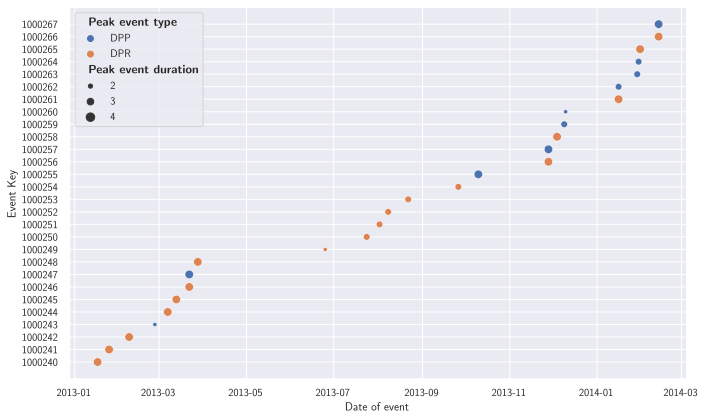

In [18]:
# activate latex text rendering for matplotlib
rc('text', usetex=True)

# Plot the seaborn graph
sns.set()
plt.figure(figsize=(10, 6))

ax = sns.scatterplot(x="EVENT_DATE", y="EVENT_KEY",
                     hue="PEAK_EVENT_TYPE", size="peak_event_duration",
                     data=peak_event_df.sort_values('EVENT_KEY', ascending=False))

# Change the axes labels and parts of legend 
ax.set(xlabel='Date of event', ylabel='Event Key')
ax.get_legend().get_texts()[0].set_text(r'\textbf{Peak event type}')
ax.get_legend().get_texts()[3].set_text(r'\textbf{Peak event duration}')

plt.tight_layout()
plt.show()

#### *Peak event plots*

We also calculate and plot some basic information of when the DPR events have happened.

In [19]:
# Get the median time of each event's start and end time 
date_offset_ser = peak_event_df.peak_event_duration.apply(lambda x: pd.DateOffset(hours=x/2))
peak_event_df['EVENT_DATETIME'] = peak_event_df.START_TIMESTAMP + date_offset_ser

C:\Users\anton\Anaconda3\envs\visualisation\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [20]:
# Create the Day, Month, Hour columns
peak_event_df.loc[:, 'Day'] = peak_event_df.EVENT_DATETIME.dt.day_name().values
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
peak_event_df['Day'] = pd.Categorical(peak_event_df['Day'], categories=cats, ordered=True)
peak_event_df.loc[:, 'Month'] = peak_event_df.EVENT_DATETIME.dt.month.values
peak_event_df.loc[:, 'Hour'] = peak_event_df.EVENT_DATETIME.dt.hour.values.astype(str)

In [21]:
# Select only the DPR events
DPR_event_df = peak_event_df[peak_event_df.PEAK_EVENT_TYPE == 'DPR']

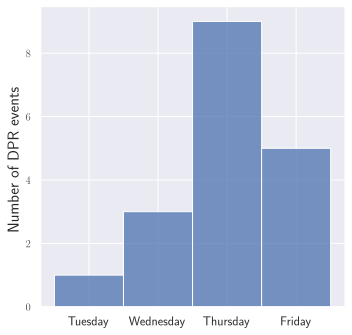

In [22]:
# Plot the number of DPR events per day
sns.displot(DPR_event_df.Day)
plt.xlabel('')
plt.ylabel('Number of DPR events', fontsize=16)
plt.xticks(fontsize= 13)

plt.show()

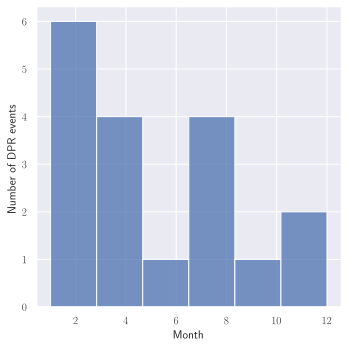

In [23]:
# Plot the number of DPR events per month
sns.displot(DPR_event_df.Month.sort_values())
plt.xlabel('Month')
plt.ylabel('Number of DPR events')

plt.show()

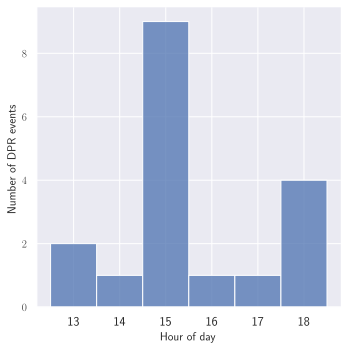

In [24]:
# Plot the number of DPR events per hour of day
sns.displot(DPR_event_df.Hour.sort_values())
plt.xlabel('Hour of day')
plt.ylabel('Number of DPR events')
plt.xticks(fontsize= 13)

plt.show()

In [25]:
# Check across seasons
winter_mask = DPR_event_df.Month.isin([6,7,8])
spring_mask = DPR_event_df.Month.isin([9,10,11])
summer_mask = DPR_event_df.Month.isin([12,1,2])
autumn_mask = DPR_event_df.Month.isin([3,4,5]) 

# Create the season column
DPR_event_df.loc[:, 'season'] = np.zeros(DPR_event_df.shape[0], dtype='str')

DPR_event_df.loc[winter_mask, 'season'] = 'Winter'
DPR_event_df.loc[spring_mask, 'season'] = 'Spring'
DPR_event_df.loc[summer_mask, 'season'] = 'Summer'
DPR_event_df.loc[autumn_mask, 'season'] = 'Autumn'

cats_season = ['Spring', 'Summer', 'Autumn', 'Winter']
DPR_event_df.loc[:, 'season'] = pd.Categorical(DPR_event_df.loc[:, 'season'], categories=cats_season, ordered=True)

C:\Users\anton\Anaconda3\envs\visualisation\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\anton\Anaconda3\envs\visualisation\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\anton\Anaconda3\envs\visualisation\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

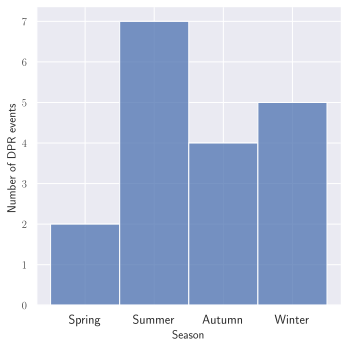

In [26]:
# Plot the number of DPR events per season
sns.displot(DPR_event_df.season)
plt.xlabel('Season')
plt.ylabel('Number of DPR events')
plt.xticks(fontsize= 13)
plt.tight_layout()

plt.show()